In [32]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [33]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [34]:
import os
import pandas as pd

benign_dirs = [
    r'D:\GitHub\4BIT\CTScan\Dataset2\Bengin cases'
]

Malignant_dir = [ r'D:\GitHub\4BIT\CTScan\Dataset2\Malignant cases']

Normal_dirs = [
    r'D:\GitHub\4BIT\CTScan\Dataset2\Malignant cases'
]

filepaths = []
labels = []
dict_lists = [benign_dirs, Malignant_dir, Normal_dirs]
class_labels = ['benign', 'Malignant', 'Normal']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Lung_data = pd.concat([Fseries, Lseries], axis=1)
Lung_df = pd.DataFrame(Lung_data)
print(Lung_df.head())
print(Lung_df["labels"].value_counts())

                                           filepaths  labels
0  D:\GitHub\4BIT\CTScan\Dataset2\Bengin cases\Be...  benign
1  D:\GitHub\4BIT\CTScan\Dataset2\Bengin cases\Be...  benign
2  D:\GitHub\4BIT\CTScan\Dataset2\Bengin cases\Be...  benign
3  D:\GitHub\4BIT\CTScan\Dataset2\Bengin cases\Be...  benign
4  D:\GitHub\4BIT\CTScan\Dataset2\Bengin cases\Be...  benign
labels
Malignant    561
Normal       561
benign       120
Name: count, dtype: int64


In [35]:
Lung_df.shape

(1242, 2)

In [36]:
train_images, test_images = train_test_split(Lung_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(Lung_df, test_size=0.2, random_state=42)

In [37]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(993, 2)
(373, 2)
(249, 2)
(869, 2)


In [38]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 993 validated image filenames belonging to 3 classes.
Found 373 validated image filenames belonging to 3 classes.
Found 249 validated image filenames belonging to 3 classes.


In [39]:
classes=list(train.class_indices.keys())
print (classes)

['Malignant', 'Normal', 'benign']


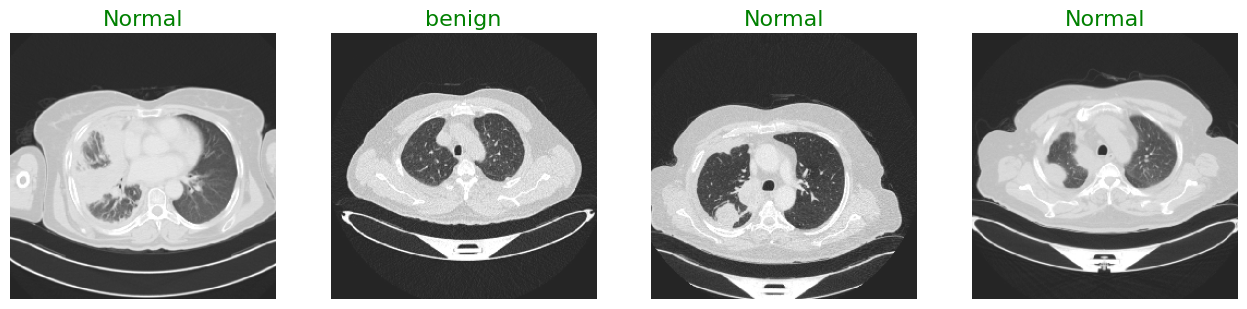

In [40]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_knee_images(train)

In [41]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 73, 73, 128)       24704     
                                                                 
 batch_normalization_9 (Bat  (None, 73, 73, 128)       512       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 73, 73, 256)       819456    
                                                                 
 batch_normalization_10 (Ba  (None, 73, 73, 256)       1024      
 tchNormalization)                                               
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 256)       0         
 g2D)                                                            
                                                      

In [42]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [43]:
history = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
249/249 [==============================] - 403s 2s/step - loss: 1.9234 - accuracy: 0.4290 - val_loss: 0.9462 - val_accuracy: 0.4819
Epoch 2/5
 99/249 [==========>...................] - ETA: 3:06 - loss: 1.3301 - accuracy: 0.4377

KeyboardInterrupt: 

In [44]:
model.save("Lung_Model.h5")

In [45]:
test

In [46]:
train.class_indices

{'Malignant': 0, 'Normal': 1, 'benign': 2}

In [47]:
pred = model.predict(test)
pred

94/94 [==============================] - 35s 367ms/step


array([[0.4434402 , 0.48560798, 0.07095186],
       [0.42783257, 0.49163795, 0.08052954],
       [0.4459968 , 0.49969298, 0.05431015],
       ...,
       [0.44211027, 0.5405572 , 0.01733257],
       [0.47539145, 0.4900592 , 0.03454928],
       [0.46473354, 0.47707337, 0.05819315]], dtype=float32)

In [48]:
pred = np.argmax(pred, axis=1) #pick class with highest  probability
pred

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,

In [49]:
labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

In [50]:
labels

{0: 'Malignant', 1: 'Normal', 2: 'benign'}

In [51]:
pred2

['Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Malignant',
 'Normal',
 'Normal',
 'Normal',
 'Malignant',
 'Malignant',
 'Malignant',
 'Malignant',
 'Normal',
 'Normal',
 'Malignant',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Malignant',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Malignant',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Malignant',
 'Malignant',
 'Normal',
 'Normal',
 'Malignant',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Malignant',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Malignant',
 'Malignant',
 'Normal',
 'Normal',
 'Normal',
 'Malignant',
 'Malignant',
 'Malignant',
 'Normal',
 'Malignant',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Malignant',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Malignant',
 'Normal',
 'Normal',
 'Normal',
 'Mal

In [52]:
import pickle
with open('cnn_classifier.pkl' , 'wb' ) as file : 
    pickle.dump(model, file)

In [53]:
# serialize weights to HDF5
model.save_weights("cnn_model.h5")
print("Saved model to disk")

Saved model to disk


In [54]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

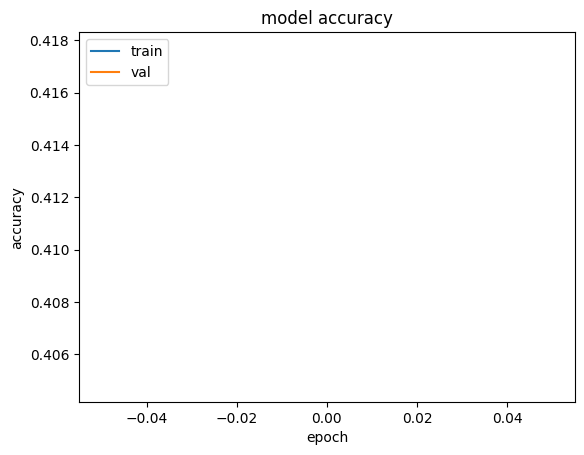

In [73]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('cnn_metrics/model_accuracy.png')
plt.show()

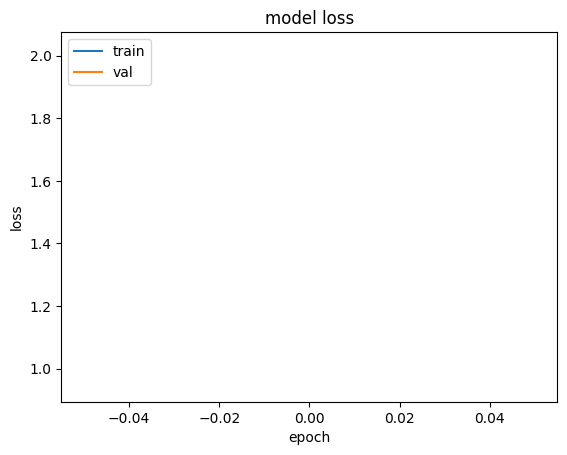

In [74]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('cnn_metrics/model_loss.png')
plt.show()

In [60]:
y_test = test_images.labels
y_test

900        Normal
1003       Normal
671     Malignant
620     Malignant
926        Normal
          ...    
299     Malignant
477     Malignant
811        Normal
1113       Normal
486     Malignant
Name: labels, Length: 373, dtype: object

In [64]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
report = classification_report(y_test , pred2 , output_dict = True)
df_classification_report = pd.DataFrame(report).transpose()
df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

   Malignant       0.47      0.27      0.34       180
      Normal       0.43      0.73      0.54       159
      benign       0.00      0.00      0.00        34

    accuracy                           0.44       373
   macro avg       0.30      0.33      0.30       373
weighted avg       0.41      0.44      0.40       373

Accuracy of the Model: 44.2%


In [76]:
#save the classification report dataframe as a png file 
#import dataframe_image as dfi
#dfi.export(df_classification_report, "/classification_report.png")

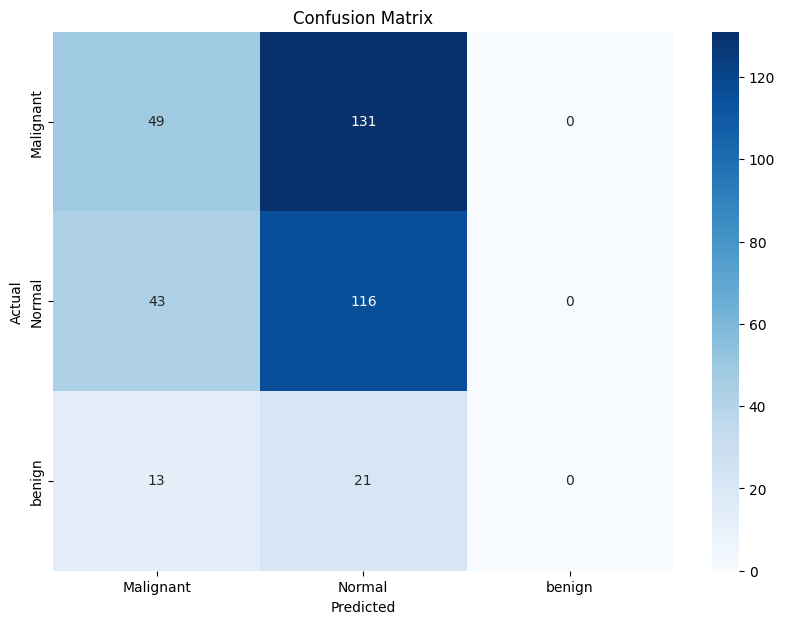

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Malignant', 'Normal', 'benign']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")
plt.savefig('cnn_metrics/confusion_matrix.png')

plt.show()